In [1]:
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import os
import shutil
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR,ARResults
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Data Manipulation

In [2]:
raw_folder = 'raw_folder'
raw_folder_renamed = 'raw_folder_renamed'
clean_folder_renamed = 'clean_folder_renamed'

In [3]:
dict_months = {
    '2015_01': [1420088400000, 1422766799000],
    '2015_02': [1422766800000, 1425185999000],
    '2015_03': [1425186000000, 1427860799000],
    '2015_04': [1427860800000, 1430452799000],
    '2015_05': [1430452800000, 1433131199000],
    '2015_06': [1433131200000, 1435723199000],
    '2015_07': [1435723200000, 1438401599000],
    '2015_08': [1438401600000, 1441079999000],
    '2015_09': [1441080000000, 1443671999000],
    '2015_10': [1443672000000, 1446350399000],
    '2015_11': [1446350400000, 1448945999000],
    '2015_12': [1448946000000, 1451624399000],
    '2016_01': [1451624400000, 1454302799000],
    '2016_02': [1454302800000, 1456808399000],
    '2016_03': [1456808400000, 1459483199000],
    '2016_04': [1459483200000, 1462075199000],
    '2016_05': [1462075200000, 1464753599000],
    '2016_06': [1464753600000, 1467345599000],
    '2016_07': [1467345600000, 1470023999000],
    '2016_08': [1470024000000, 1472702399000],
    '2016_09': [1472702400000, 1475294399000],
    '2016_10': [1475294400000, 1477972799000],
    '2016_11': [1477972800000, 1480568399000],
    '2016_12': [1480568400000, 1483246799000],
    '2017_01': [1483246800000, 1485925199000],
    '2017_02': [1485925200000, 1488344399000],
    '2017_03': [1488344400000, 1491019199000],
    '2017_04': [1491019200000, 1493611199000],
    '2017_05': [1493611200000, 1496289599000],
    '2017_06': [1496289600000, 1498881599000],
    '2017_07': [1498881600000, 1501559999000],
    '2017_08': [1501560000000, 1504238399000],
    '2017_09': [1504238400000, 1506830399000],
    '2017_10': [1506830400000, 1509508799000],
    '2017_11': [1509508800000, 1512104399000],
    '2017_12': [1512104400000, 1514782799000],
    '2018_01': [1514782800000, 1517461199000],
    '2018_02': [1517461200000, 1519880399000],
    '2018_03': [1519880400000, 1522555199000],
    '2018_04': [1522555200000, 1525147199000],
    '2018_05': [1525147200000, 1527825599000],
    '2018_06': [1527825600000, 1530417599000],
    '2018_07': [1530417600000, 1533095999000],
    '2018_08': [1533096000000, 1535774399000],
    '2018_09': [1535774400000, 1538366399000],
    '2018_10': [1538366400000, 1541044799000],
    '2018_11': [1541044800000, 1543640399000],
    '2018_12': [1543640400000, 1546318799000],
    '2019_01': [1546318800000, 1548997199000],
    '2019_02': [1548997200000, 1551416399000],
    '2019_03': [1551416400000, 1554091199000],
    '2019_04': [1554091200000, 1556683199000],
    '2019_05': [1556683200000, 1559361599000],
    '2019_06': [1559361600000, 1561953599000],
    '2019_07': [1561953600000, 1564631999000],
    '2019_08': [1564632000000, 1567310399000],
    '2019_09': [1567310400000, 1569902399000],
    '2019_10': [1569902400000, 1572580799000],
    '2019_11': [1572580800000, 1575176399000],
    '2019_12': [1575176400000, 1577854799000]
}

In [4]:
for month, url in dict_months.items():
    print(f'{month} = https://www.clover.com/reporting/sales-report?endTimestamp={url[1]}&startTimestamp={url[0]}')

2015_01 = https://www.clover.com/reporting/sales-report?endTimestamp=1422766799000&startTimestamp=1420088400000
2015_02 = https://www.clover.com/reporting/sales-report?endTimestamp=1425185999000&startTimestamp=1422766800000
2015_03 = https://www.clover.com/reporting/sales-report?endTimestamp=1427860799000&startTimestamp=1425186000000
2015_04 = https://www.clover.com/reporting/sales-report?endTimestamp=1430452799000&startTimestamp=1427860800000
2015_05 = https://www.clover.com/reporting/sales-report?endTimestamp=1433131199000&startTimestamp=1430452800000
2015_06 = https://www.clover.com/reporting/sales-report?endTimestamp=1435723199000&startTimestamp=1433131200000
2015_07 = https://www.clover.com/reporting/sales-report?endTimestamp=1438401599000&startTimestamp=1435723200000
2015_08 = https://www.clover.com/reporting/sales-report?endTimestamp=1441079999000&startTimestamp=1438401600000
2015_09 = https://www.clover.com/reporting/sales-report?endTimestamp=1443671999000&startTimestamp=144108

In [5]:
## Put files in the root directory
## File names are required to be named as: EL IMAN RESTAURANT-Sales Report 01-07-2020.csv
## That is how clover default saves the file 

index = 0
for month, url in dict_months.items():
    if month == '2015_01':
        cleaned_df = pd.read_csv(f'{raw_folder}/EL IMAN RESTAURANT-Sales Report 01-07-2020.csv', header=1, skiprows=11)
        if cleaned_df.columns[-1] != 'Total':
            cleaned_df = pd.read_csv(f'{raw_folder}/EL IMAN RESTAURANT-Sales Report 01-07-2020.csv', header=1, skiprows=10)
        shutil.copyfile(f'{raw_folder}/EL IMAN RESTAURANT-Sales Report 01-07-2020.csv', f"{raw_folder_renamed}/{month}_el_iman_sales_report.csv")
        cleaned_df.to_csv(f"{clean_folder_renamed}/{month}_el_iman_sales_report_cleaned.csv", index=False)
    else:
        index += 1
        cleaned_df = pd.read_csv(f'{raw_folder}/EL IMAN RESTAURANT-Sales Report 01-07-2020 ({index}).csv', header=1, skiprows=11)
        if cleaned_df.columns[-1] != 'Total':
            cleaned_df = pd.read_csv(f'{raw_folder}/EL IMAN RESTAURANT-Sales Report 01-07-2020 ({index}).csv', header=1, skiprows=10)
        shutil.copyfile(f'{raw_folder}/EL IMAN RESTAURANT-Sales Report 01-07-2020.csv', f"{raw_folder_renamed}/{month}_el_iman_sales_report.csv")        
        cleaned_df.to_csv(f"{clean_folder_renamed}/{month}_el_iman_sales_report_cleaned.csv", index=False)
                
for filename in os.listdir(clean_folder_renamed):
    if 'cleaned.csv' in filename:
        df = pd.read_csv(f'{clean_folder_renamed}/{filename}')
        
        for index in range(df.shape[0]):
            if df.loc[index][0] == 'Net Sales':
                net_sales = index

        df_net_sales = pd.DataFrame(df.iloc[net_sales])
        df_net_sales.columns = df_net_sales.iloc[0]
        df_net_sales = df_net_sales[1:]
        
        #drop 'totals row'
        df_net_sales.drop(df_net_sales.tail(1).index,inplace=True)

        df_net_sales.to_csv(f'csv/{filename[:7]}_net_sales.csv', header=False)

for filename in os.listdir('csv'):
    if '_net_sales.csv' in filename:
        df = pd.read_csv(f'csv/{filename}', header=None)
        df.columns = ['date','total']
        df['date'] = df['date'] + ' ' + filename[:4]
        df.to_csv(f'csv/{filename[:7]}_net_sales.csv', header=True, index=False)
        
list_csv_files = []
for infile in glob.glob("csv/*.csv"):
    dataframe = pd.read_csv(infile)
    list_csv_files.append(dataframe)
    
df = pd.concat(list_csv_files, sort=False, ignore_index=True)
df['total'] = df['total'].str.replace("$", "").str.replace(",", "")
df['date'] = pd.to_datetime(df['date'])
df['total'] = df['total'].astype(float)
df = df.sort_values(by=['date'])
df.to_csv(f'net_sales_total.csv', header=True, index=False)

# Load Clean CSV

In [97]:
df = pd.read_csv('net_sales_total.csv')
# df = pd.read_csv('net_sales_total.csv', index_col='date', parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
df

,date,total
0,2015-01-01,0.00
1,2015-01-02,0.00
2,2015-01-03,0.00
3,2015-01-04,0.00
4,2015-01-05,0.00
...,...,...
1826,2019-12-27,2325.50
1827,2019-12-28,3277.75
1828,2019-12-29,3919.75
1829,2019-12-30,2041.50


In [98]:
df.dtypes

date     datetime64[ns]
total           float64
dtype: object

In [99]:
df = df[df['total']>100]

In [100]:
df

,date,total
13,2015-01-14,1200.00
14,2015-01-15,1497.25
15,2015-01-16,2624.75
16,2015-01-17,4190.00
17,2015-01-18,4329.50
...,...,...
1826,2019-12-27,2325.50
1827,2019-12-28,3277.75
1828,2019-12-29,3919.75
1829,2019-12-30,2041.50


In [104]:
daily_sales = df.set_index('date')
#df.set_index('date', inplace=True)

In [105]:
daily_sales

,total
date,
2015-01-14,1200.00
2015-01-15,1497.25
2015-01-16,2624.75
2015-01-17,4190.00
2015-01-18,4329.50
...,...
2019-12-27,2325.50
2019-12-28,3277.75
2019-12-29,3919.75


# EDA

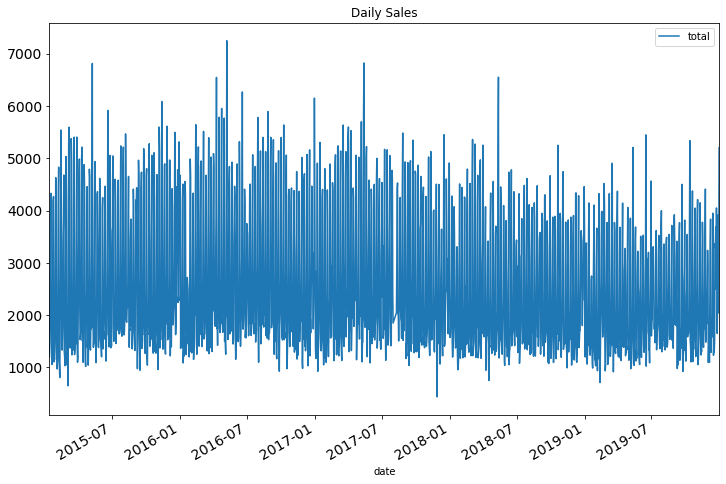

In [107]:
daily_sales.plot(figsize=(12,8), title = 'Daily Sales', fontsize=14)

In [12]:
monthly_sales = daily_sales.resample('m').sum()

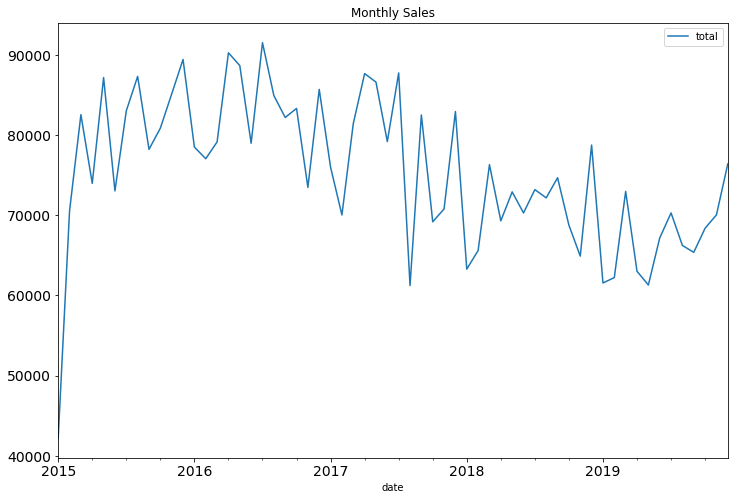

In [13]:
monthly_sales = pd.DataFrame(monthly_sales, columns=['total'])
monthly_sales.plot(figsize=(12,8), title= 'Monthly Sales', fontsize=14)

In [14]:
monthly_sales.shift(1).head()

,total
date,
2015-01-31,NaN
2015-02-28,42210.25
2015-03-31,70553.75
2015-04-30,82572.75
2015-05-31,73997.25


In [15]:
monthly_sales.rolling(window=12).mean().head(20)

,total
date,
2015-01-31,NaN
2015-02-28,NaN
2015-03-31,NaN
2015-04-30,NaN
2015-05-31,NaN
2015-06-30,NaN
2015-07-31,NaN
2015-08-31,NaN
2015-09-30,NaN


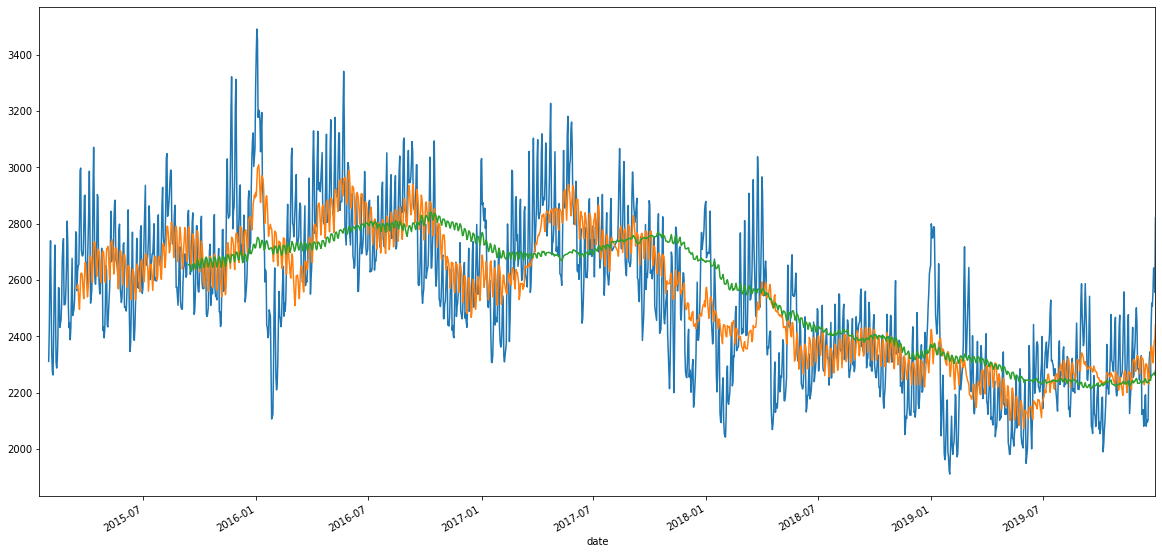

In [16]:
plt.figure(figsize=(20,10))
# line, = ax.plot([1, 2, 3])
# line.set_label('Label via method')
# ax.legend()

daily_sales.rolling(window=15).mean().plot()
# daily_sales.rolling(window=30).mean().plot()
daily_sales.rolling(window=60).mean().plot()
# daily_sales.rolling(window=120).mean().plot()
daily_sales.rolling(window=240).mean().plot()

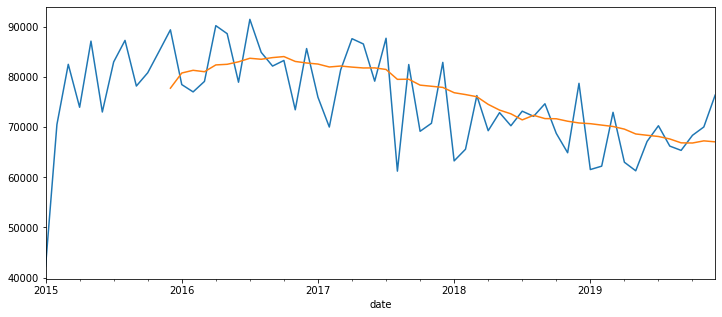

In [17]:
monthly_sales['total'].plot(figsize=(12,5)).autoscale(axis='x',tight=True)
monthly_sales.rolling(window=12).mean()['total'].plot();

<Figure size 432x288 with 0 Axes>

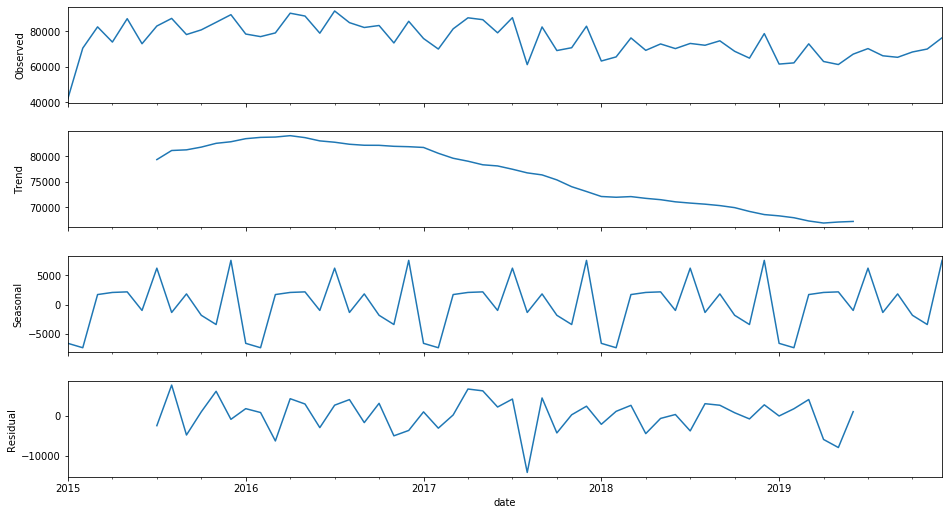

In [18]:
decomposition = seasonal_decompose(monthly_sales, freq=12 )
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [19]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

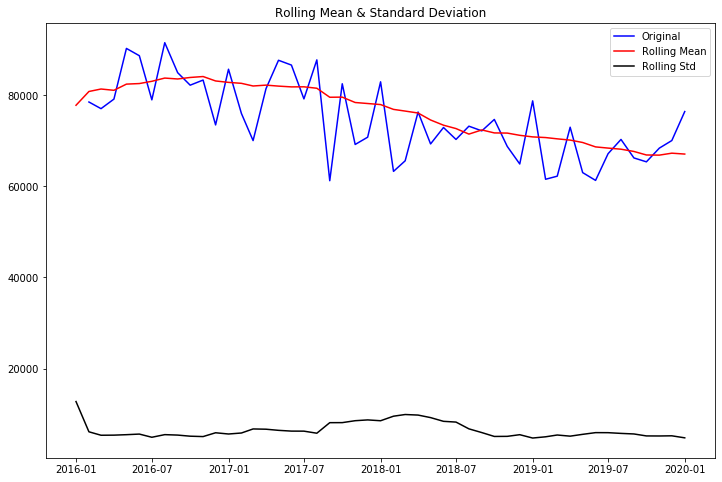

Results of Dickey-Fuller Test:
Test Statistic                 -1.833952
p-value                         0.363740
#Lags Used                      2.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


In [20]:
test_stationarity(monthly_sales.total, 12)

### Log Transformation

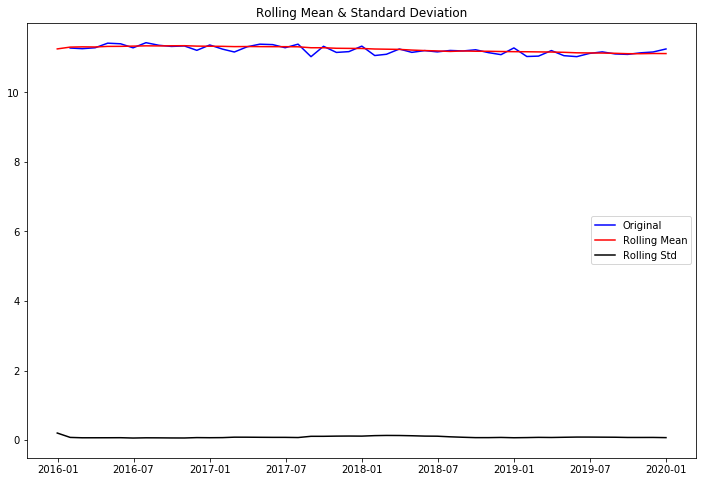

Results of Dickey-Fuller Test:
Test Statistic                 -1.942940
p-value                         0.312138
#Lags Used                      2.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


In [21]:
monthly_sales['natural_log'] = monthly_sales.total.apply(lambda x: np.log(x))  
test_stationarity(monthly_sales.natural_log, 12)

### First Difference

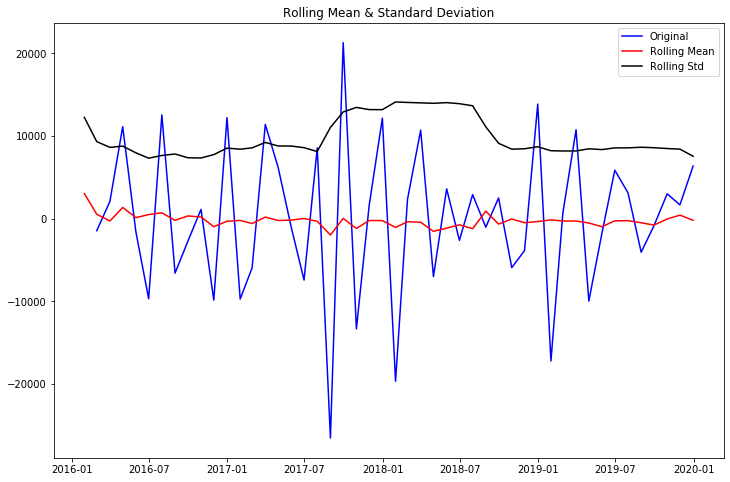

Results of Dickey-Fuller Test:
Test Statistic                 -3.463762
p-value                         0.008968
#Lags Used                     10.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


In [22]:
monthly_sales['first_difference'] = monthly_sales.total - monthly_sales.total.shift(1)  
test_stationarity(monthly_sales.first_difference.dropna(inplace=False),12)

### Seasonal Difference

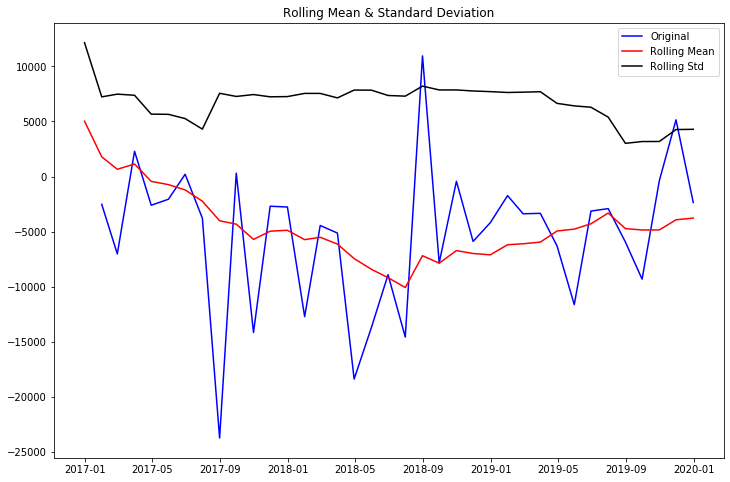

Results of Dickey-Fuller Test:
Test Statistic                -7.317721e+00
p-value                        1.216848e-10
#Lags Used                     0.000000e+00
Number of Observations Used    4.700000e+01
Critical Value (1%)           -3.577848e+00
Critical Value (5%)           -2.925338e+00
Critical Value (10%)          -2.600774e+00
dtype: float64


In [23]:
monthly_sales['seasonal_difference'] = monthly_sales.total - monthly_sales.total.shift(12)  
test_stationarity(monthly_sales.seasonal_difference.dropna(inplace=False), 12)

### Seasonal Difference of the First Difference

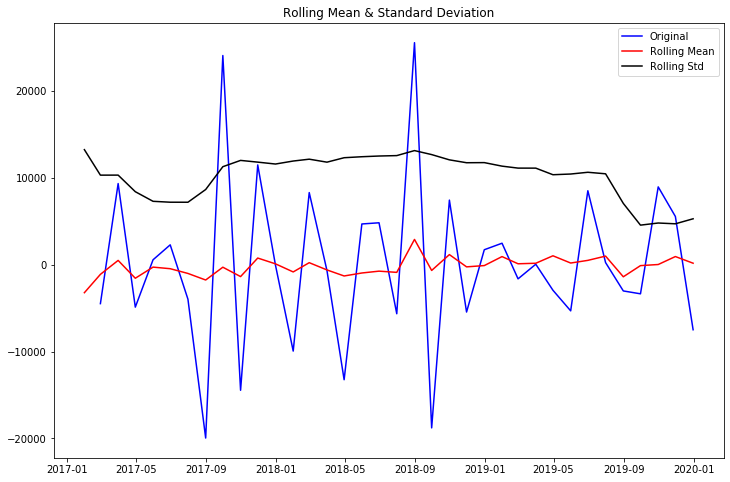

Results of Dickey-Fuller Test:
Test Statistic                 -3.567480
p-value                         0.006414
#Lags Used                      7.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


In [24]:
monthly_sales['seasonal_first_difference'] = monthly_sales.first_difference - monthly_sales.first_difference.shift(12)  
test_stationarity(monthly_sales.seasonal_first_difference.dropna(inplace=False), 12)

## Season Difference of the log first difference

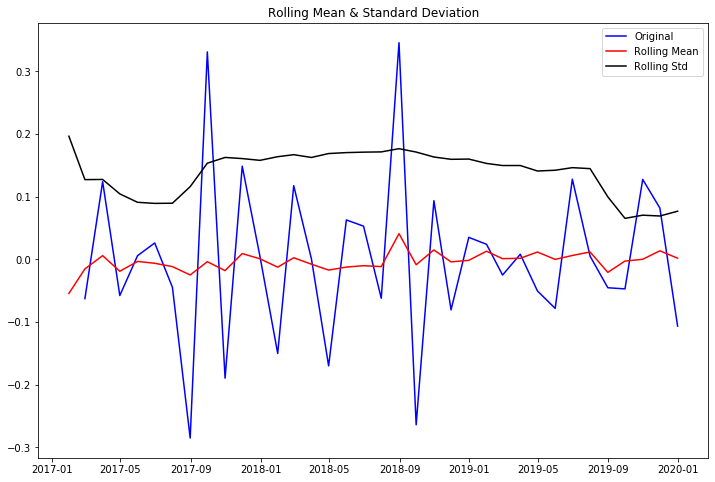

Results of Dickey-Fuller Test:
Test Statistic                -1.127285e+01
p-value                        1.521760e-20
#Lags Used                     1.000000e+00
Number of Observations Used    4.500000e+01
Critical Value (1%)           -3.584829e+00
Critical Value (5%)           -2.928299e+00
Critical Value (10%)          -2.602344e+00
dtype: float64


In [25]:
monthly_sales['log_first_difference'] = monthly_sales.natural_log - monthly_sales.natural_log.shift(1)  
monthly_sales['log_seasonal_first_difference'] = monthly_sales.log_first_difference - monthly_sales.log_first_difference.shift(12)  

# test_stationarity(monthly_sales.log_first_difference.dropna(inplace=False), 12)
test_stationarity(monthly_sales.log_seasonal_first_difference.dropna(inplace=False), 12)


### Plotting

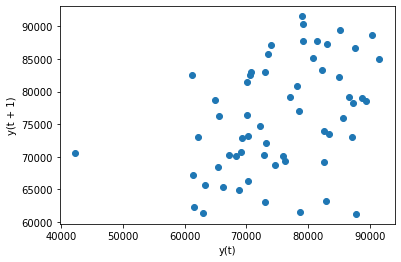

In [26]:
lag_plot(monthly_sales['total']);

In [27]:
monthly_sales['first_difference'] = monthly_sales.total - monthly_sales.total.shift(1)  
monthly_sales['seasonal_first_difference'] = monthly_sales.first_difference - monthly_sales.first_difference.shift(12)  

### ACF

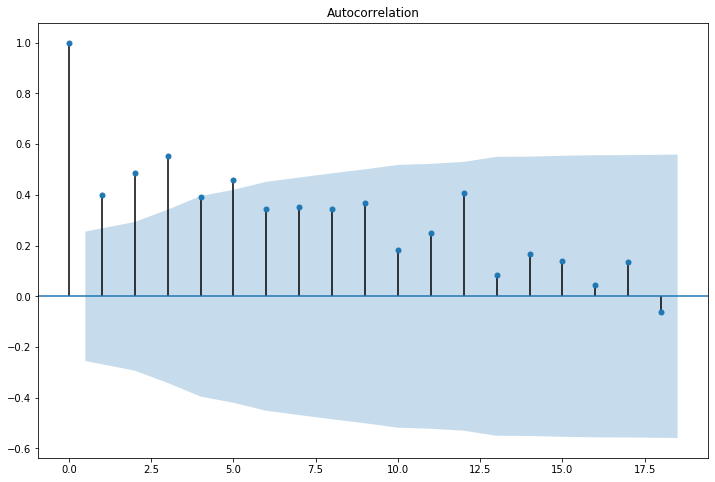

In [28]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.total.iloc[1:], lags=18, ax=ax1)

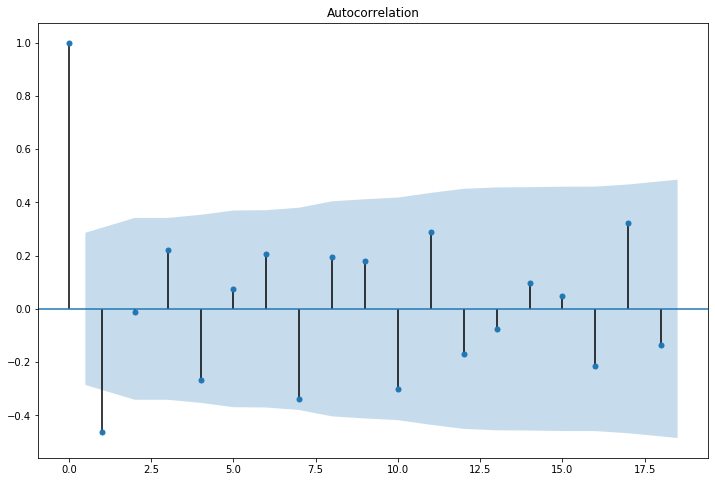

In [29]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.seasonal_first_difference.iloc[13:], lags=18, ax=ax1)

### Partial Correlation

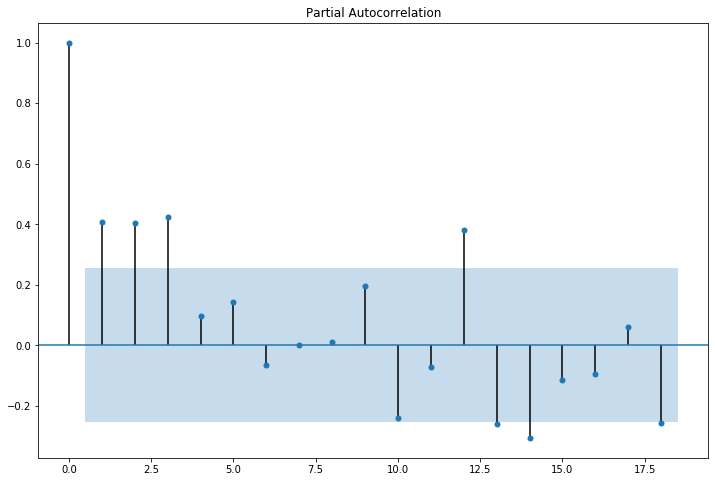

In [30]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.total.iloc[1:], lags=18, ax=ax1)

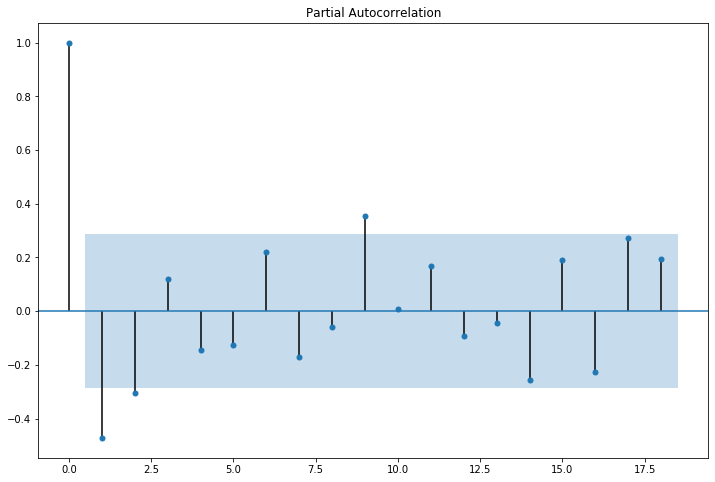

In [31]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.seasonal_first_difference.iloc[13:], lags=18, ax=ax1)

In [32]:
len(monthly_sales)

60

In [33]:
monthly_sales.head()

,total,natural_log,first_difference,seasonal_difference,seasonal_first_difference,log_first_difference,log_seasonal_first_difference
date,,,,,,,
2015-01-31,42210.25,10.650418,NaN,NaN,NaN,NaN,NaN
2015-02-28,70553.75,11.164130,28343.50,NaN,NaN,0.513712,NaN
2015-03-31,82572.75,11.321435,12019.00,NaN,NaN,0.157305,NaN
2015-04-30,73997.25,11.211783,-8575.50,NaN,NaN,-0.109652,NaN
2015-05-31,87204.62,11.376013,13207.37,NaN,NaN,0.164229,NaN


# Train Test Split

In [34]:
train = monthly_sales['total'].iloc[:48]
test  = monthly_sales['total'].iloc[48:]

# AR(p) (autoregressive model)
## AR(1)

In [35]:
model = AR(train)
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
Coefficients:
const       62118.081311
L1.total        0.196285
dtype: float64


In [36]:
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

In [37]:
predictions1

2019-01-31    77581.107774
2019-02-28    77346.077814
2019-03-31    77299.944993
2019-04-30    77290.889818
2019-05-31    77289.112425
2019-06-30    77288.763549
2019-07-31    77288.695071
2019-08-31    77288.681629
2019-09-30    77288.678991
2019-10-31    77288.678473
2019-11-30    77288.678371
2019-12-31    77288.678351
Freq: M, Name: AR(1) Predictions, dtype: float64

In [38]:
for i in range(len(predictions1)):
    print(f"predicted={predictions1[i]:<11.10}, expected={test[i]}")

predicted=77581.10777, expected=61560.0
predicted=77346.07781, expected=62236.75
predicted=77299.94499, expected=72989.5
predicted=77290.88982, expected=63022.75
predicted=77289.11242, expected=61309.75
predicted=77288.76355, expected=67172.25
predicted=77288.69507, expected=70307.0
predicted=77288.68163, expected=66245.5
predicted=77288.67899, expected=65388.520000000004
predicted=77288.67847, expected=68396.25
predicted=77288.67837, expected=70063.83
predicted=77288.67835, expected=76429.75


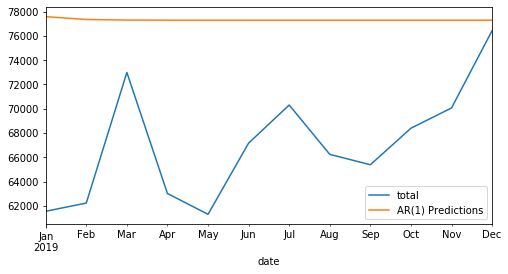

In [39]:
test.plot(legend=True)
predictions1.plot(legend=True,figsize=(8,4));

## AR(2)

In [40]:
AR2fit = model.fit(maxlag=2,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')

Lag: 2
Coefficients:
const       53357.349044
L1.total        0.158276
L2.total        0.149576
dtype: float64


In [41]:
start=len(train)
end=len(train)+len(test)-1
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

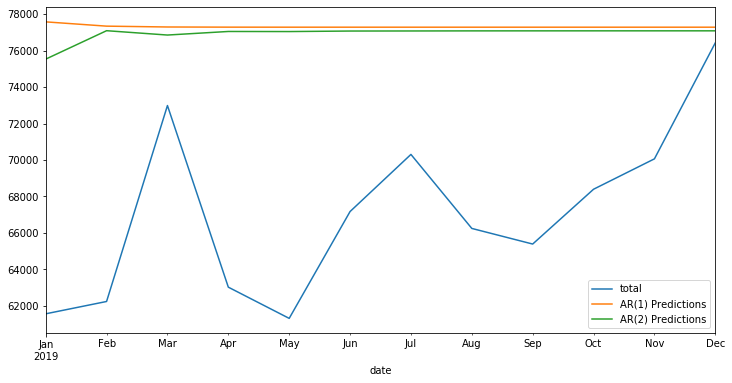

In [42]:
test.plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

## AR(p) w/auto p

In [43]:
ARfit = model.fit(method='mle')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 10
Coefficients:
const        11436.348105
L1.total         0.258041
L2.total         0.204915
L3.total         0.324399
L4.total        -0.150307
L5.total         0.356718
L6.total        -0.213033
L7.total         0.005168
L8.total         0.095913
L9.total         0.275011
L10.total       -0.312654
dtype: float64


/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [44]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(11) Predictions'

predictions11 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

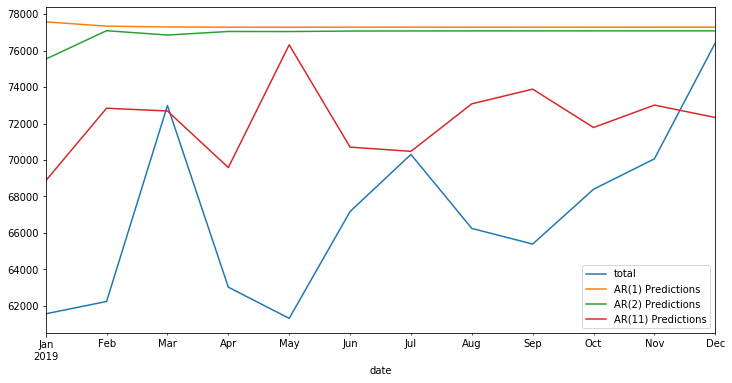

In [45]:
test.plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions11.plot(legend=True,figsize=(12,6));

## AR(40)

In [46]:
AR40fit = model.fit(maxlag=40,method='mle')
print(f'Lag: {AR40fit.k_ar}')
print(f'Coefficients:\n{AR40fit.params}')

Lag: 40
Coefficients:
const        0.020250
L1.total     0.499017
L2.total     0.945625
L3.total     0.039035
L4.total     0.158714
L5.total    -0.236314
L6.total    -0.699105
L7.total    -0.180254
L8.total     0.615525
L9.total     0.256560
L10.total   -0.064448
L11.total   -0.281679
L12.total   -0.156923
L13.total   -0.219289
L14.total   -0.272656
L15.total    0.394062
L16.total    0.009800
L17.total    0.372290
L18.total    0.116714
L19.total   -0.334418
L20.total   -0.172296
L21.total    0.029649
L22.total    0.220104
L23.total    0.265738
L24.total    0.233139
L25.total   -0.068655
L26.total   -0.093065
L27.total   -0.548347
L28.total   -0.399230
L29.total   -0.154226
L30.total    0.396421
L31.total    0.937545
L32.total   -0.460031
L33.total   -0.112493
L34.total   -0.198445
L35.total   -0.459586
L36.total    0.441692
L37.total    0.750501
L38.total   -0.229371
L39.total   -0.439559
L40.total    0.097940
dtype: float64


/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [47]:
start=len(train)
end=len(train)+len(test)-1
rename = f'AR(40) Predictions'
predictions40 = AR40fit.predict(start=start, end=end, dynamic=False).rename('AR(40) Predictions')

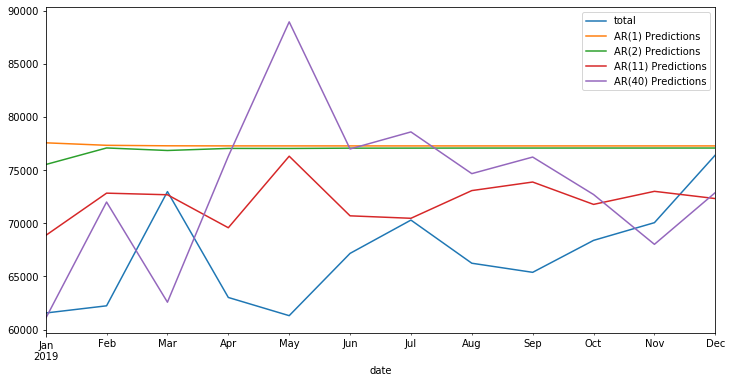

In [48]:
test.plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions11.plot(legend=True)
predictions40.plot(legend=True,figsize=(12,6));

## Evaluation Metrics

In [49]:
labels = ['AR(1)','AR(2)','AR(11)', 'AR(40)']
preds = [predictions1, predictions2, predictions11, predictions40]  # these are variables, not strings!

for i in range(4):
    error = mean_squared_error(test, preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 125761040.6
AR(2) Error: 116621081.2
AR(11) Error: 50232225.27
AR(40) Error: 127948925.0


In [50]:
modls = [AR1fit,AR2fit,ARfit, AR40fit]

for i in range(4):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: 13.781
AR(2) AIC: 13.823
AR(11) AIC: 14.156
AR(40) AIC: 15.406


/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


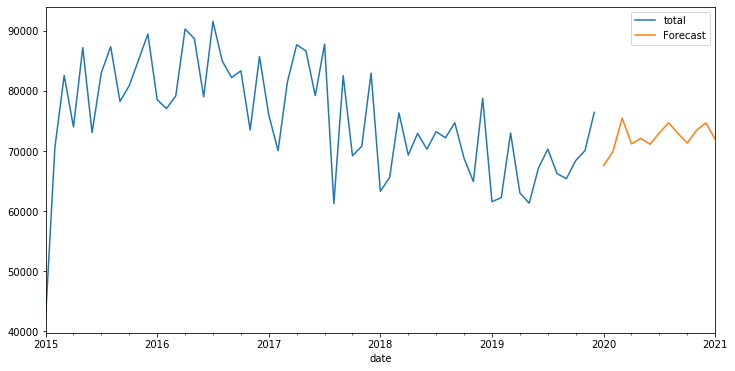

In [51]:
# First, retrain the model on the full dataset
model = AR(monthly_sales['total'])

# Next, fit the model
ARfit = model.fit(maxlag=11,method='mle')

# Make predictions
# fcast = ARfit.predict(start=len(monthly_sales), end=len(monthly_sales)+6, dynamic=False).rename('Forecast')
fcast = ARfit.predict(start=len(monthly_sales), end=len(monthly_sales)+12, dynamic=False).rename('Forecast')

# Plot the results
monthly_sales['total'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));

## ARIMA / SARIMA

In [52]:
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 1, 0, 12)
SARIMAX: (0, 1, 0) x (1, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (1, 1, 0, 12)
SARIMAX: (0, 1, 1) x (1, 1, 1, 12)
SARIMAX: (1, 1, 0) x (0, 1, 0, 12)
SARIMAX: (1, 1, 0) x (0, 1, 1, 12)
SARIMAX: (1, 1, 0) x (1, 1, 0, 12)
SARIMAX: (1, 1, 0) x (1, 1, 1, 12)
SARIMAX: (1, 1, 1) x (0, 1, 0, 12)
SARIMAX: (1, 1, 1) x (0, 1, 1, 12)
SARIMAX: (1, 1, 1) x (1, 1, 0, 12)
SARIMAX: (1, 1, 1) x (1, 1, 1, 12)


In [53]:
y = monthly_sales['total']

In [54]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            results = mod.fit()
            print(f'ARIMA{param}x{param_seasonal}12 - AIC:{results.aic}')
        except: 
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:978.4478045721058


/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1292.9434223309866
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:744.0874963607874


/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1388.307304368571
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:934.4268011131179


/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1694.198043595349
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:726.0656294049736


/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1417.6826451865686
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:966.6864498757035


/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1324.5023961330426
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:709.8312292969986


/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1379.666903270988
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:929.7731898738748


/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1574.0231980110225
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:705.0420166225242
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1412.0915065267204


/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## ACF PACF

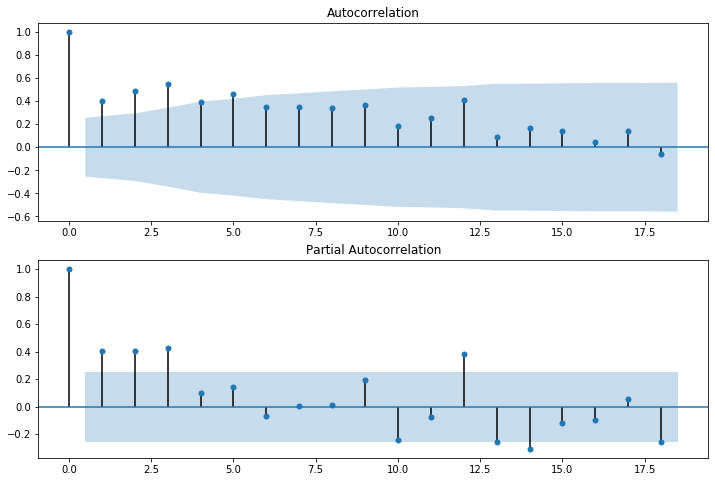

In [55]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.total.iloc[1:], lags=18, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.total.iloc[1:], lags=18, ax=ax2)

### First Difference

In [56]:
monthly_sales['first_difference'] = monthly_sales.total - monthly_sales.total.shift(1)  

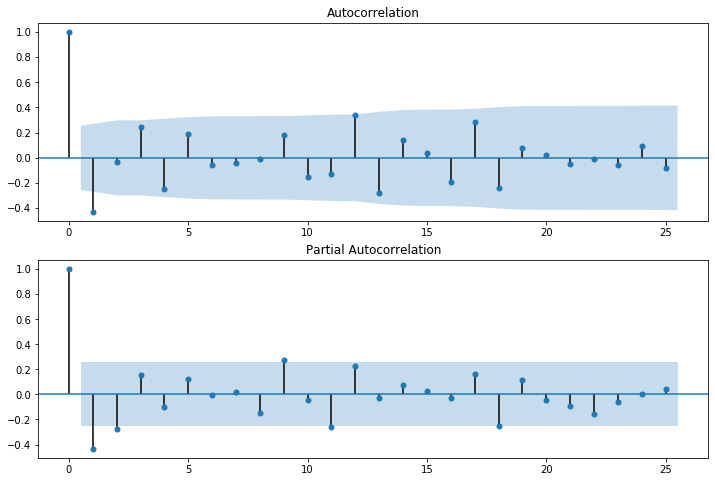

In [57]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.first_difference.iloc[1:], lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.first_difference.iloc[1:], lags=25, ax=ax2)

### Seasonal First Difference

In [58]:
monthly_sales['seasonal_first_difference'] = monthly_sales.first_difference - monthly_sales.first_difference.shift(12)

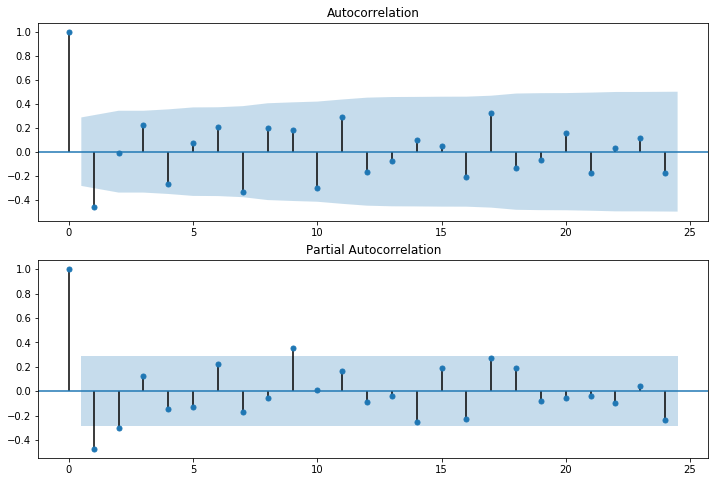

In [59]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.seasonal_first_difference.iloc[13:], lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.seasonal_first_difference.iloc[13:], lags=24, ax=ax2)

### Auto Arima

In [108]:
%%time
auto_arima(daily_sales['total'], seasonal = True, m = 12, n_jobs = -1).summary()

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/pmdarima/arima/auto.py:302: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Convergence

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kennymiyasato/

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sa

CPU times: user 13min 46s, sys: 10.5 s, total: 13min 57s
Wall time: 10min 50s


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1774
Model:             SARIMAX(5, 1, 5)x(0, 0, 2, 12)   Log Likelihood              -14273.531
Date:                            Wed, 08 Jan 2020   AIC                          28575.062
Time:                                    16:22:03   BIC                          28651.788
Sample:                                         0   HQIC                         28603.406
                                           - 1774                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.4316      2.823      0.861      0.389      -3.102       7.965
ar.L1          0.3995      0.067      5.948      0.000       0.268       0.531
ar.L2         -1.1168      0.055    -20.258      0.000      -1.225      -1.009
ar.L3          0.2515      0.093      2.698      0.007       0.069       0.434
ar.L4         -0.7173      0.051    -14.113      0.000      -0.817      -0.618
ar.L5         -0.3128      0.061     -5.158      0.000      -0.432      -0.194
ma.L1         -1.3298      0.062    -21.542      0.000      -1.451      -1.209
ma.L2          1.2929      0.093     13.868      0.000       1.110       1.476
ma.L3         -1.2778      0.084    -15.124      0.000      -1.443      -1.112
ma.L4          0.8830      0.080     11.037      0.000       0.726       1.040
ma.L5         -0.4964      0.044    -11.284      0.000      -0.583      -0.410
ma.S.L12       0.1310      0.047      2.809      0.005       0.040       0.222
ma.S.L24      -0.0608      0.049     -1.248      0.212      -0.156       0.035
sigma2      8.854e+05   3.76e+04     23.558      0.000    8.12e+05    9.59e+05
===================================================================================
Ljung-Box (Q):                      300.84   Jarque-Bera (JB):               367.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.19
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
%%time
auto_arima(monthly_sales['total'], seasonal = True, m = 12, n_jobs = -1).summary()

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/pmdarima/arima/auto.py:302: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 748 ms, sys: 9.03 ms, total: 757 ms
Wall time: 756 ms


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -626.735
Date:                Wed, 08 Jan 2020   AIC                           1255.471
Time:                        15:14:28   BIC                           1257.548
Sample:                             0   HQIC                          1256.281
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.702e+07   1.59e+07      6.083      0.000    6.58e+07    1.28e+08
===================================================================================
Ljung-Box (Q):                       81.60   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.00   Prob(JB):                         0.79
Heteroskedasticity (H):               0.41   Skew:                            -0.03
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [189]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(5, 1, 4),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              total   No. Observations:                   48
Model:             SARIMAX(5, 1, 4)x(1, 0, 1, 12)   Log Likelihood            -5933124.048
Date:                            Wed, 08 Jan 2020   AIC                       11866272.096
Time:                                    14:52:11   BIC                       11866288.911
Sample:                                01-31-2015   HQIC                      11866277.475
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       -340.8525      0.001  -3.48e+05      0.000    -340.854    -340.851
ar.L2       -373.5054      0.002  -

In [190]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(5,1,4)(1,0,1,12) Predictions')

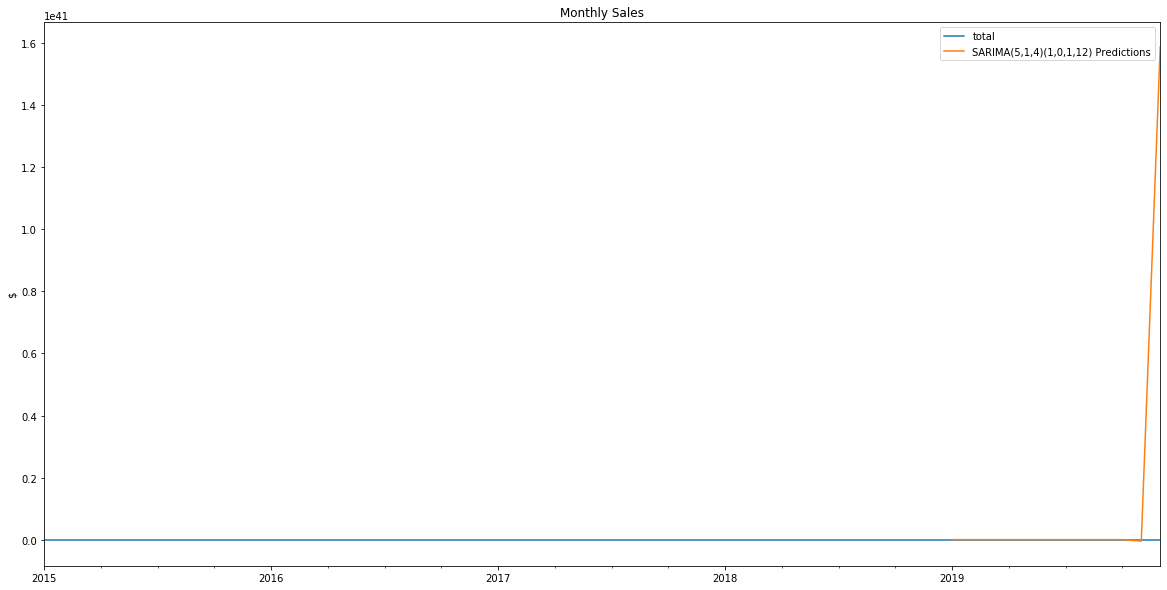

In [192]:
title = 'Monthly Sales'
ylabel='$'
xlabel=''

ax = monthly_sales['total'].plot(legend=True,figsize=(20,10),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);